                  
                              Zadanie 2:  Model  Przewidywania  Kolejnego  Słowa

Na początek - trochę teorii..

                    
                           Ogólna charakterystyka rekurencyjnych sieci neuronowych:
                       
   
   RNN, LSTM i GRU to rodzaje sieci neuronowych używanych w zadaniach analizy sekwencji danych, takich jak przetwarzanie języka naturalnego, rozpoznawanie mowy, lub przetwarzanie muzyki.


   RNN (Recurrent Neural Network) to sieć neuronowa, która ma wewnętrzny stan, który jest przekazywany między kolejnymi krokami czasowymi przetwarzania danych sekwencyjnych. RNN jest skuteczny w przetwarzaniu sekwencji danych, ale może mieć trudności z zapamiętaniem długoterminowych zależności. W takich przypadkach mogą okazać się bardziej skuteczne bardziej złożone architektury, takie jak LSTM i GRU.


   LSTM (Long Short-Term Memory) to rodzaj sieci neuronowej RNN, który zaprojektowano w celu przetwarzania sekwencji danych z długoterminowymi zależnościami. LSTM posiada dodatkowe warstwy zwane bramkami, które kontrolują, jakie informacje powinny być zapamiętane, a jakie powinny być odrzucone. Bramki te umożliwiają sieciom LSTM zapamiętanie ważnych informacji na dłuższy czas, co przyczynia się do lepszej wydajności w zadaniach wymagających analizy długoterminowych zależności w sekwencjach danych.


   GRU (Gated Recurrent Unit) to kolejna odmiana sieci neuronowej RNN, podobna do LSTM, ale z mniejszą ilością warstw. W przeciwieństwie do LSTM, GRU ma tylko dwie bramki: bramkę resetowania i bramkę aktualizacji, której zadaniem jest kontrolowanie informacji przekazywanych między kolejnymi krokami czasowymi. Dzięki temu GRU może być mniej skomplikowany i szybszy w treningu niż LSTM, ale wciąż oferuje dobry poziom skuteczności w przetwarzaniu długoterminowych zależności w sekwencjach danych.


   Podsumowując, RNN jest prostą i skuteczną siecią neuronową do przetwarzania sekwencji danych, ale może mieć trudności z zapamiętaniem długoterminowych zależności. LSTM i GRU są bardziej złożonymi sieciami neuronowymi RNN, które są skuteczne w przetwarzaniu sekwencji danych z długoterminowymi zależnościami. LSTM oferuje więcej warstw bramek do kontroli informacji, co daje mu większą zdolność do zapamiętania długoterminowych zależności. GRU jest bardziej kompaktowy niż LSTM, ale nadal oferuje kontrolę nad informacjami przekazywanymi między krokami czasowymi.


   Przykładowa architektura sieci może składać się z warstw:


'Embedding' - reprezentacja wektorowa dla każdego tokena. Jako argument potrzebuje wiedzieć 3 rzeczy: jak dużo mamy unikalnych               tokenów i jaką chcemy posiadać dla nich reprezentację wektorową (max_top_words), jak długi ma być ten wektor                   embedding_vecor_length oraz jaka jest długość wektora danych wyjściowych - max_length,


'Dense' - węzeł na końcu,


'Flatten' - pozwala przełączyć się z 3D na 2D (wejście Dense).


In [1]:
import torch
import numpy as np
import pandas as pd
import random
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.functional import one_hot
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchtext

In [2]:
filename = 'Pan Tadeusz.txt'

with open(filename, 'r', encoding='utf-8') as f:
    text = f.readlines()

text[:20]

['    Litwo! Ojczyzno moja! ty jesteś jak zdrowie:\n',
 'Ile cię trzeba cenić, ten tylko się dowie,\n',
 'Kto cię stracił. Dziś piękność twą w całej ozdobie\n',
 'Widzę i opisuję, bo tęsknię po tobie.\n',
 '\n',
 '    Panno święta, co Jasnej bronisz Częstochowy\n',
 'I w Ostrej świecisz Bramie! Ty, co gród zamkowy\n',
 'Nowogródzki ochraniasz z jego wiernym ludem!\n',
 'Jak mnie dziecko do zdrowia powróciłaś cudem\n',
 '(Gdy od płaczącej matki, pod Twoją opiekę\n',
 'Ofiarowany, martwą podniosłem powiekę;\n',
 'I zaraz mogłem pieszo, do Twych świątyń progu\n',
 'Iść za wrócone życie podziękować Bogu),\n',
 'Tak nas powrócisz cudem na Ojczyzny łono.\n',
 'Tymczasem przenoś moją duszę utęsknioną\n',
 'Do tych pagórków leśnych, do tych łąk zielonych,\n',
 'Szeroko nad błękitnym Niemnem rozciągnionych;\n',
 'Do tych pól malowanych zbożem rozmaitem,\n',
 'Wyzłacanych pszenicą, posrebrzanych żytem;\n',
 'Gdzie bursztynowy świerzop, gryka jak śnieg biała,\n']

In [3]:
# Tworzymy jedną linię tekstu:

data = ""

for i in text:
    data = ' '.join(text)

data[:2000]

'    Litwo! Ojczyzno moja! ty jesteś jak zdrowie:\n Ile cię trzeba cenić, ten tylko się dowie,\n Kto cię stracił. Dziś piękność twą w całej ozdobie\n Widzę i opisuję, bo tęsknię po tobie.\n \n     Panno święta, co Jasnej bronisz Częstochowy\n I w Ostrej świecisz Bramie! Ty, co gród zamkowy\n Nowogródzki ochraniasz z jego wiernym ludem!\n Jak mnie dziecko do zdrowia powróciłaś cudem\n (Gdy od płaczącej matki, pod Twoją opiekę\n Ofiarowany, martwą podniosłem powiekę;\n I zaraz mogłem pieszo, do Twych świątyń progu\n Iść za wrócone życie podziękować Bogu),\n Tak nas powrócisz cudem na Ojczyzny łono.\n Tymczasem przenoś moją duszę utęsknioną\n Do tych pagórków leśnych, do tych łąk zielonych,\n Szeroko nad błękitnym Niemnem rozciągnionych;\n Do tych pól malowanych zbożem rozmaitem,\n Wyzłacanych pszenicą, posrebrzanych żytem;\n Gdzie bursztynowy świerzop, gryka jak śnieg biała,\n Gdzie panieńskim rumieńcem dzięcielina pała,\n A wszystko przepasane jakby wstęgą, miedzą\n Zieloną, na niej z r

In [4]:
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('"', '').replace('"', '')
data[:2000]

'    Litwo! Ojczyzno moja! ty jesteś jak zdrowie: Ile cię trzeba cenić, ten tylko się dowie, Kto cię stracił. Dziś piękność twą w całej ozdobie Widzę i opisuję, bo tęsknię po tobie.      Panno święta, co Jasnej bronisz Częstochowy I w Ostrej świecisz Bramie! Ty, co gród zamkowy Nowogródzki ochraniasz z jego wiernym ludem! Jak mnie dziecko do zdrowia powróciłaś cudem (Gdy od płaczącej matki, pod Twoją opiekę Ofiarowany, martwą podniosłem powiekę; I zaraz mogłem pieszo, do Twych świątyń progu Iść za wrócone życie podziękować Bogu), Tak nas powrócisz cudem na Ojczyzny łono. Tymczasem przenoś moją duszę utęsknioną Do tych pagórków leśnych, do tych łąk zielonych, Szeroko nad błękitnym Niemnem rozciągnionych; Do tych pól malowanych zbożem rozmaitem, Wyzłacanych pszenicą, posrebrzanych żytem; Gdzie bursztynowy świerzop, gryka jak śnieg biała, Gdzie panieńskim rumieńcem dzięcielina pała, A wszystko przepasane jakby wstęgą, miedzą Zieloną, na niej z rzadka ciche grusze siedzą.      Śród takich 

In [5]:
data = data.split()
data = ' '.join(data)
data[:2000]

'Litwo! Ojczyzno moja! ty jesteś jak zdrowie: Ile cię trzeba cenić, ten tylko się dowie, Kto cię stracił. Dziś piękność twą w całej ozdobie Widzę i opisuję, bo tęsknię po tobie. Panno święta, co Jasnej bronisz Częstochowy I w Ostrej świecisz Bramie! Ty, co gród zamkowy Nowogródzki ochraniasz z jego wiernym ludem! Jak mnie dziecko do zdrowia powróciłaś cudem (Gdy od płaczącej matki, pod Twoją opiekę Ofiarowany, martwą podniosłem powiekę; I zaraz mogłem pieszo, do Twych świątyń progu Iść za wrócone życie podziękować Bogu), Tak nas powrócisz cudem na Ojczyzny łono. Tymczasem przenoś moją duszę utęsknioną Do tych pagórków leśnych, do tych łąk zielonych, Szeroko nad błękitnym Niemnem rozciągnionych; Do tych pól malowanych zbożem rozmaitem, Wyzłacanych pszenicą, posrebrzanych żytem; Gdzie bursztynowy świerzop, gryka jak śnieg biała, Gdzie panieńskim rumieńcem dzięcielina pała, A wszystko przepasane jakby wstęgą, miedzą Zieloną, na niej z rzadka ciche grusze siedzą. Śród takich pól przed laty

In [6]:
len(data)

8041

In [7]:
characters_to_remove = [',', '.', ':', '!', '?', ';', '-', ',', '(', ')']

for char in characters_to_remove:
    data = data.replace(char, '')

data[:2000]

'Litwo Ojczyzno moja ty jesteś jak zdrowie Ile cię trzeba cenić ten tylko się dowie Kto cię stracił Dziś piękność twą w całej ozdobie Widzę i opisuję bo tęsknię po tobie Panno święta co Jasnej bronisz Częstochowy I w Ostrej świecisz Bramie Ty co gród zamkowy Nowogródzki ochraniasz z jego wiernym ludem Jak mnie dziecko do zdrowia powróciłaś cudem Gdy od płaczącej matki pod Twoją opiekę Ofiarowany martwą podniosłem powiekę I zaraz mogłem pieszo do Twych świątyń progu Iść za wrócone życie podziękować Bogu Tak nas powrócisz cudem na Ojczyzny łono Tymczasem przenoś moją duszę utęsknioną Do tych pagórków leśnych do tych łąk zielonych Szeroko nad błękitnym Niemnem rozciągnionych Do tych pól malowanych zbożem rozmaitem Wyzłacanych pszenicą posrebrzanych żytem Gdzie bursztynowy świerzop gryka jak śnieg biała Gdzie panieńskim rumieńcem dzięcielina pała A wszystko przepasane jakby wstęgą miedzą Zieloną na niej z rzadka ciche grusze siedzą Śród takich pól przed laty nad brzegiem ruczaju Na pagórku

In [8]:
data = data.replace('okien-', 'okien ')
data = data.replace('dziewczyna...', 'dziewczyna')
data = data.replace('komnaty...', 'komnaty')
data = data.replace('<<Dobrze', 'Dobrze')
data = data.replace('damy>>', 'damy')
data[:2000]

'Litwo Ojczyzno moja ty jesteś jak zdrowie Ile cię trzeba cenić ten tylko się dowie Kto cię stracił Dziś piękność twą w całej ozdobie Widzę i opisuję bo tęsknię po tobie Panno święta co Jasnej bronisz Częstochowy I w Ostrej świecisz Bramie Ty co gród zamkowy Nowogródzki ochraniasz z jego wiernym ludem Jak mnie dziecko do zdrowia powróciłaś cudem Gdy od płaczącej matki pod Twoją opiekę Ofiarowany martwą podniosłem powiekę I zaraz mogłem pieszo do Twych świątyń progu Iść za wrócone życie podziękować Bogu Tak nas powrócisz cudem na Ojczyzny łono Tymczasem przenoś moją duszę utęsknioną Do tych pagórków leśnych do tych łąk zielonych Szeroko nad błękitnym Niemnem rozciągnionych Do tych pól malowanych zbożem rozmaitem Wyzłacanych pszenicą posrebrzanych żytem Gdzie bursztynowy świerzop gryka jak śnieg biała Gdzie panieńskim rumieńcem dzięcielina pała A wszystko przepasane jakby wstęgą miedzą Zieloną na niej z rzadka ciche grusze siedzą Śród takich pól przed laty nad brzegiem ruczaju Na pagórku

In [9]:
data = data.lower()
data[:2000]

'litwo ojczyzno moja ty jesteś jak zdrowie ile cię trzeba cenić ten tylko się dowie kto cię stracił dziś piękność twą w całej ozdobie widzę i opisuję bo tęsknię po tobie panno święta co jasnej bronisz częstochowy i w ostrej świecisz bramie ty co gród zamkowy nowogródzki ochraniasz z jego wiernym ludem jak mnie dziecko do zdrowia powróciłaś cudem gdy od płaczącej matki pod twoją opiekę ofiarowany martwą podniosłem powiekę i zaraz mogłem pieszo do twych świątyń progu iść za wrócone życie podziękować bogu tak nas powrócisz cudem na ojczyzny łono tymczasem przenoś moją duszę utęsknioną do tych pagórków leśnych do tych łąk zielonych szeroko nad błękitnym niemnem rozciągnionych do tych pól malowanych zbożem rozmaitem wyzłacanych pszenicą posrebrzanych żytem gdzie bursztynowy świerzop gryka jak śnieg biała gdzie panieńskim rumieńcem dzięcielina pała a wszystko przepasane jakby wstęgą miedzą zieloną na niej z rzadka ciche grusze siedzą śród takich pól przed laty nad brzegiem ruczaju na pagórku

In [11]:
corpus = str(data)
corpus[:2000]

'litwo ojczyzno moja ty jesteś jak zdrowie ile cię trzeba cenić ten tylko się dowie kto cię stracił dziś piękność twą w całej ozdobie widzę i opisuję bo tęsknię po tobie panno święta co jasnej bronisz częstochowy i w ostrej świecisz bramie ty co gród zamkowy nowogródzki ochraniasz z jego wiernym ludem jak mnie dziecko do zdrowia powróciłaś cudem gdy od płaczącej matki pod twoją opiekę ofiarowany martwą podniosłem powiekę i zaraz mogłem pieszo do twych świątyń progu iść za wrócone życie podziękować bogu tak nas powrócisz cudem na ojczyzny łono tymczasem przenoś moją duszę utęsknioną do tych pagórków leśnych do tych łąk zielonych szeroko nad błękitnym niemnem rozciągnionych do tych pól malowanych zbożem rozmaitem wyzłacanych pszenicą posrebrzanych żytem gdzie bursztynowy świerzop gryka jak śnieg biała gdzie panieńskim rumieńcem dzięcielina pała a wszystko przepasane jakby wstęgą miedzą zieloną na niej z rzadka ciche grusze siedzą śród takich pól przed laty nad brzegiem ruczaju na pagórku

In [12]:
len(corpus)

7769

In [13]:
corpus_tokens = corpus.split()
corpus_tokens[:15]

['litwo',
 'ojczyzno',
 'moja',
 'ty',
 'jesteś',
 'jak',
 'zdrowie',
 'ile',
 'cię',
 'trzeba',
 'cenić',
 'ten',
 'tylko',
 'się',
 'dowie']

In [14]:
len(corpus_tokens)

1246

In [15]:
token_to_remove = "-"

if token_to_remove in corpus_tokens:
    corpus_tokens.remove(token_to_remove)

corpus_tokens[:15]

['litwo',
 'ojczyzno',
 'moja',
 'ty',
 'jesteś',
 'jak',
 'zdrowie',
 'ile',
 'cię',
 'trzeba',
 'cenić',
 'ten',
 'tylko',
 'się',
 'dowie']

In [16]:
len(corpus_tokens)  # ??

1246


  Przygotowujemy dane (tekstowe), aby móc użyć ich do trenowania modelu przewidującego kolejne słowa w sekwencji. Przygotowanie danych obejmuje tokenizację tekstu (etap powyżej), stworzenie słownika (indeksowania słów), a także transformację tekstu na sekwencje liczb reprezentujących słowa. Następnie dane zostaną podzielone na sekwencje wejściowe i wyjściowe, co umożliwi modelowi przewidywanie kolejnych słów w oparciu o wcześniejsze słowa.


In [17]:
# Tworzenie słownika (indeksowanie słów):

from collections import Counter


word_counts = Counter(corpus_tokens)  # Zliczamy liczbę wystąpień każdego słowa w 'corpus_tokens'

sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)  # Sortujemy słownictwo po częstości występowania słów

word_to_index = {word: idx for idx, word in enumerate(sorted_vocab)}  # Mapujemy słowo na indeks

index_to_word = {idx: word for word, idx in word_to_index.items()}  # Kluczami są indeksy słów a wartościami - same słowa


In [ ]:
# Ile razy dane słowo występuje w zbiorze tokenów:

#word_counts

In [18]:
len(word_counts)

825

In [ ]:
#sorted_vocab

In [19]:
len(sorted_vocab)

825

In [ ]:
#word_to_index

In [20]:
len(word_to_index)

825

In [21]:
for i in range(0, 10):

    print(f"{i}: {index_to_word[i]}")

0: i
1: w
2: na
3: z
4: się
5: do
6: nie
7: od
8: że
9: jak


In [22]:
len(index_to_word)

825

Dla przypomnienia:
    
    1. Oryginalny tekst:  "Litwo ojczyzno moja"
    
    2. Lista tokenów:  ['litwo', 'ojczyzno', 'moja']
    
    3. Słownik:  {'litwo': 0, 'ojczyzno': 1, 'moja': 2}
    
    4. Lista z ID słów:  [0, 1, 2]

    5. Sekwencje: [['litwo'], ['litwo', 'ojczyzno'], ['litwo', 'ojczyzno', 'moja']]  
    
    6. Ngram:  1-gramy: "litwo", "ojczyzno", "moja",
               2-gramy: "litwo ojczyzno", "ojczyzno moja",
               3-gram:  "litwo ojczyzno moja"
              

                                       Przygotowanie danych:
                                       
Kiedy przygotowujemy do treningu większą ilość dokumentów (tekstów) warto rozważyć zastosowanie techniki TD-IDF. W danym dokumencie (zbiorze tekstów) pewne słowa mogą występować częściej. Inne (dłuższe) dokumenty mają większą szansę na to, że tokeny (słowa) będą się powtarzać, jednak proporcje mogą być podobne (np. dane słowo występuje w dwóch dokumentach co piąte, mimo, że pierwszy dokument ma 100 słów a drugi 1000 - proporcje są porównywalne). Stąd koncepcja, aby podzielić liczbę wystąpień danego tokena przez długość dokumentu (tekstu), czyli liczbę wszystkich tokenów). W ten sposób dokonujemy normalizacji. Stosowanie TF-IDF umożliwia określenie ważności słowa w tekście, czy porównanie ważności słów w różnych tekstach. TF-IDF, dla jednego dokumentu (tekstu), nie uwzględnia istotności słów w kontekście.

In [23]:
# Przygotowanie danych:

sequence_length = 5  # Długość sekwencji wejściowej

data_X = []
data_y = []


for i in range(len(corpus_tokens) - sequence_length):


    # Sekwencja wejściowa, która pobiera 'sequence_length' kolejnych tokenów z 'corpus_tokens':

    seq_in = corpus_tokens[i:i + sequence_length]

    # Sekwencja wyjściowa, która odpowiada tokenowi, który znajduje się za sekwencją wejściową o długości 'sequence_length':

    seq_out = corpus_tokens[i + sequence_length]

    # Przekształcenie sekwencji wejściowej na listę indeksów tokenów. Każdy token z sekwencji wejściowej jest mapowany
    # na odpowiadający mu indeks za pomocą słownika 'word_to_index', + dodanie listy indeksów do listy 'data_X':

    data_X.append([word_to_index[word] for word in seq_in])

    # Mapowanie sekwencji wyjściowej na indeks tokenu przy użyciu słownika 'word_to_index', + dodanie indeksu do listy 'data_y':

    data_y.append(word_to_index[seq_out])


In [24]:
X = data_X
X[:10]

[[121, 122, 123, 50, 124],
 [122, 123, 50, 124, 9],
 [123, 50, 124, 9, 125],
 [50, 124, 9, 125, 126],
 [124, 9, 125, 126, 51],
 [9, 125, 126, 51, 127],
 [125, 126, 51, 127, 128],
 [126, 51, 127, 128, 129],
 [51, 127, 128, 129, 18],
 [127, 128, 129, 18, 4]]

In [25]:
len(X)

1241

In [26]:
y = data_y
y[:10]

[9, 125, 126, 51, 127, 128, 129, 18, 4, 130]

In [27]:
len(y)

1241

In [28]:
train_split = int(0.8 * len(X))
train_split

992

In [29]:
X_train, y_train = X[:train_split], y[:train_split]

In [30]:
len(X_train), len(y_train)

(992, 992)

In [31]:
X_test, y_test = X[train_split:], y[train_split:]

In [32]:
len(X_test), len(y_test)

(249, 249)

In [33]:
# Konwersja danych na PyTorch'owe tensory:

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

In [34]:
X_train

tensor([[121, 122, 123,  50, 124],
        [122, 123,  50, 124,   9],
        [123,  50, 124,   9, 125],
        ...,
        [691, 692,  28, 693,   5],
        [692,  28, 693,   5, 694],
        [ 28, 693,   5, 694, 109]])

In [35]:
X_train.shape

torch.Size([992, 5])

In [36]:
y_train

tensor([  9, 125, 126,  51, 127, 128, 129,  18,   4, 130, 131,  51, 132,  52,
        133, 134,   1, 135, 136, 137,   0, 138,  10, 139,  13, 140, 141, 142,
         11, 143, 144, 145,   0,   1, 146, 147, 148,  50,  11, 149, 150, 151,
        152,   3,  53, 153, 154,   9, 155,  54,   5, 156, 157,  55,  22,   7,
        158, 159,  23, 160, 161, 162, 163, 164, 165,   0, 166, 167, 168,   5,
        169, 170, 171, 172,  30, 173, 174, 175, 176,  31,  56, 177,  55,   2,
        178, 179,  57, 180, 181, 182, 183,   5,  32, 184, 185,   5,  32, 186,
        187, 188,  58, 189, 190, 191,   5,  32,  59, 192, 193, 194, 195, 196,
        197, 198,  33, 199, 200, 201,   9, 202,  60,  33, 203, 204, 205, 206,
         14,  61, 207, 208, 209, 210, 211,   2,  62,   3, 212, 213, 214, 215,
        216, 217,  59,  16,  34,  58, 218, 219,   2, 220, 221,  24, 222, 223,
         63, 224, 225,   3, 226,  17, 227, 228,   4,   3, 229, 230,  64,  35,
        231,   8, 232,   7, 233, 234, 235,  11,  36, 236,   7, 2

In [37]:
y_train.shape

torch.Size([992])

In [38]:
# "Opakowujemy" dane w PyTorch'owy DataLoader: (pozwala na łatwiejsze wczytywanie danych partiami podczas trenowania modelu):

batch_size = 32

dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [39]:
dataset

In [40]:
len(dataset)

992

In [41]:
train_loader

In [42]:
len(train_loader)

31

In [43]:
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [44]:
X_test

tensor([[693,   5, 694, 109,   6],
        [  5, 694, 109,   6, 695],
        [694, 109,   6, 695, 696],
        ...,
        [  0, 119, 820, 821, 822],
        [119, 820, 821, 822,   0],
        [820, 821, 822,   0, 823]])

In [45]:
X_test.shape

torch.Size([249, 5])

In [46]:
y_test

tensor([695, 696,  90,   6, 697, 698, 699,   1,  12, 700, 701,  88, 109, 110,
         20,   4,  29,  49, 702, 111, 703,  30, 704, 705, 706, 112, 113, 707,
          0, 112,   1, 708, 113, 709,  27, 710,   0,  76,  28, 711, 712, 713,
          0, 714,  12, 715, 716,   2, 717, 718,  13, 719,  10,   6, 114, 720,
        721,   1, 722, 723, 724, 100,   9, 114, 725, 726,  98, 727,   3,  46,
         10,   7,  46, 107,   8,  40, 728, 729,   3, 730,  28, 731,  29,  49,
         83,   3, 732, 101, 733,   0,   3, 734, 105, 735,   0, 736, 737,   4,
        738, 739, 740, 741,   1, 742, 743, 115, 116, 744, 745,   1, 746, 747,
          0, 748,   1, 749, 750, 751, 752,   0, 753,   0, 108, 754,  22,   4,
         29,  49, 755, 756, 757,   2, 758, 759, 116, 760, 761, 762, 763, 117,
        118,  10,  31, 764, 103, 111, 765, 766, 767,   2, 768,   8,   1, 769,
        770,   4, 771,  67, 117, 118, 772,   4,  52, 773,   5,  12,  69, 774,
        775, 776, 777, 778, 779, 119, 780, 781, 782, 783,   3, 7

In [47]:
y_test.shape

torch.Size([249])

In [48]:
batch_size = 32

dataset1 = TensorDataset(X_test, y_test)

test_loader = DataLoader(dataset1, batch_size=batch_size, shuffle=True)

In [49]:
dataset1

In [50]:
len(dataset1)

249

In [51]:
test_loader

In [52]:
len(test_loader)

8

                                            Teorii ciąg dalszy..


                                               Osadzanie słów:

Osadzenia słów można tworzyć na dwa sposoby:


Mogą one być uczone wraz z głównym zadaniem (np. klasyfikacją dokumentu lub przewidywaniem sentymentu). W takim przypadku pracę zaczyna się od losowych wektorów słów, a następnie zawartość tych wektorów jest uczona w taki sam sposób jak wagi sieci neuronowej.


Do modelu można załadować osadzenia słów utworzone podczas pracy nad innym problemem uczenia maszynowego. Takie osadzenia określamy mianem uprzednio wytrenowanych osadzeń słów.


Ad.1 Uczenie osadzeń słów przy użyciu warstwy osadzającej:

Najprostszym sposobem powiązania gęstego wektora ze słowem jest wybranie losowego wektora. Problemem z takim rozwiązaniem jest to, że wynikowa przestrzeń osadzeń nie ma struktury — np. słowa piękny i śliczny mogą skończyć w zupełnie różnych osadzeniach pomimo tego, że w większości zdań są to synonimy. Sieć neuronowa może mieć problem z uporządkowaniem tak zaszumianej i pozbawionej struktury przestrzeni osadzeń.

Geometryczna zależność między wektorami słów powinna odzwierciedlać semantyczną zależność między tymi słowami. Osadzenia słów mają odzwierciedlać język w przestrzeni geometrycznej. W poprawnej przestrzeni osadzeń synonimy powinny być osadzone w podobnych wektorach słów. Ogólnie rzecz biorąc, odległość geometryczna (np. odległość L2) między dowolnymi dwoma słowami powinna odzwierciedlać różnicę semantyczną między nimi. W przestrzeni osadzeń nie tylko odległość ma znaczenie — również kierunki powinny mieć określone znaczenie.

W rzeczywistości przestrzenie osadzania pozwalają na wykonanie transformacji zmieniających płeć lub uzyskanie liczby mnogiej. Dodając wektor „rodzaju żeńskiego” do wektora „król”, uzyskamy wektor „królowa”. Dodając do wektora „król” wektor „liczba mnoga”, uzyskamy wektor „królowie”. Przestrzenie osadzeń słów zwykle zawierają tysiące wektorów, które można zinterpretować i z których można potencjalnie skorzystać.

W praktyce to, czy dana przestrzeń osadzeń jest dobra, zależy głównie od problemu, który chcemy rozwiązać. Idealna przestrzeń osadzeń słów języka angielskiego modelu analizy sentymentu recenzji filmów wygląda inaczej od idealnej przestrzeni osadzeń słów języka angielskiego modelu klasyfikującego dokumenty prawne. Wynika to z tego, że w każdym z tych problemów ważne są inne zależności semantyczne. W związku z tym warto trenować nową przestrzeń osadzeń przy okazji rozwiązywania nowego problemu. Proces ten ułatwia algorytm propagacji wstecznej. Wszystko sprowadza się do wyuczenia wartości wag warstwy osadzania Embedding.

Warstwę Embedding najlepiej jest rozumieć jako słownik mapujący całkowitoliczbowe indeksy oznaczające określone słowa na gęste wektory. Przyjmuje ona na wejściu wartości całkowitoliczbowe i wyszukuje je w wewnętrznym słowniku, zwracając związane z nimi wektory. Warstwa Embedding przyjmuje na wejściu dwuwymiarowy tensor o kształcie (próbki, długość_sekwencji). Każdy element tego tensora jest sekwencją liczb całkowitych. Warstwa ta może osadzać sekwencje o zmiennej długości: do zaprezentowanej w poprzednim przykładzie warstwy Embedding możliwe jest kierowanie wsadów o kształcie (32, 10) (32 sekwencje o długości równej 10) lub wsadów o kształcie (64, 15) (wsad 64 sekwencji o długości 15). Wszystkie sekwencje wchodzące w skład wsadu muszą mieć tę samą długość (wynika to z faktu umieszczania ich w tym samym tensorze), a więc sekwencje, które są krótsze od innych, należy dopełnić zerami, a sekwencje, które są dłuższe, należy uciąć. Warstwa ta zwraca trójwymiarowy tensor zmiennoprzecinkowy o kształcie (próbki, długość_sekwencji, liczba_wymiarów_osadzenia). Taki trójwymiarowy tensor może zostać przetworzony przez warstwę RNN lub jednowymiarową warstwę konwolucyjną. Podczas tworzenia instancji warstwy Embedding jej wagi (wewnętrzny słownik wektorów tokenów) są inicjowane losowo (tak jak w przypadku każdej innej warstwy). Podczas trenowania wektory słów są stopniowo dostrajane przy użyciu algorytmu propagacji wstecznej, co prowadzi do uzyskania przestrzeni, z której może korzystać model. Po pełnym wytrenowaniu przestrzeń osadzeń będzie miała charakter struktury wyspecjalizowanej pod kątem rozwiązywania problemu, do którego trenowany jest model.


Ad. 2 Używanie trenowanych wcześniej osadzeń słów:

Czasami dysponuje się tak małą ilością dostępnych danych, że niemożliwe jest korzystanie z samych tych danych w celu wytrenowania osadzenia słów właściwego dla problemu.

Zamiast trenować osadzenia słów łącznie z rozwiązywanym problemem, można w takim przypadku załadować osadzające wektory z utworzonej wcześniej przestrzeni osadzania, o której wiadomo, że ma odpowiednią strukturę i właściwości — ujmuje ogólne aspekty struktury języka.

Tego typu osadzenia słów tworzy się zwykle, korzystając ze statystyk występowania słów (obserwacji tego, jakie słowa występują obok siebie w zdaniach lub dokumentach). Robi się to za pomocą wielu technik. Niektóre z nich są oparte na sieciach neuronowych.

Istnieje wiele gotowych baz osadzeń słów. Jednym z takich rozwiązań jest 'Word2vec' (już zaimplementowany w PyTorch) czy GloVe.

                                                   Definicja modelu:

In [53]:
vocab_size = len(word_counts)

embedding_dim = 128  # Wymiar osadzenia słów. Warstwa 'Embedding' mapuje każde słowo na wektor o długości 'embedding_dim'

hidden_dim = 200  # Wymiar ukrytej warstwy LSTM, tj. liczba neuronów w warstwie LSTM

import torch
import torch.nn as nn

class NextWordPredictionLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):

        super(NextWordPredictionLSTM, self).__init__()

        # Inicjujemy warstwę osadzającą:

        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        # Inicjujemy warstwę LSTM, która przetwarza osadzenia słów.
        # 'embedding_dim - rozmiar wejścia do warstwy LSTM'
        # 'hidden_dim' - liczba neuronów w warstwie ukrytej

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)


        # Inicjujemy warstwę 'full connected', która wykonuje prognozy
        # 'hidden_dim' i 'vocab_size' oznaczają odpowiednio wejście do warstwy i wyjście

        self.fc = nn.Linear(hidden_dim, vocab_size)



    # Metoda 'forward' definiuje przepływ danych przez model, wykonuje operacje na danych od warstwy wejściowej do wyjściowej:

    def forward(self, x):

        # ..mapuje indeksy słów na ich osadzenia:

        embedded = self.embedding(x)


        # ..przekazuje osadzenia słów przez warstwę LSTM dając wynik 'lstm_out':

        lstm_out, _ = self.lstm(embedded)


        # ..wykonuje prognozy, przewidując klejne słowo na podstawie ostatniego elementu sekwencji (ostatniego kroku czasowego):

        output = self.fc(lstm_out[:, -1, :])

        return output  # wynik prognoz


In [76]:
# Tworzenie instancji modelu:

model = NextWordPredictionLSTM(vocab_size, embedding_dim, hidden_dim)
model


NextWordPredictionLSTM(
  (embedding): Embedding(825, 128)
  (lstm): LSTM(128, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=825, bias=True)
)

                                        Funkcja straty i optymalizator:

Funkcja straty i optymalizator są kluczowymi elementami procesu trenowania modelu w sieciach neuronowych. Dobra funkcja straty pozwala ocenić, jak bardzo wyniki modelu różnią się od rzeczywistych danych, podczas gdy optymalizator służy do dostosowania wag modelu, aby minimalizować tę stratę. W przypadku modeli językowych takich jak przewidywanie kolejnych słów, popularną funkcją straty jest nn.CrossEntropyLoss, a jako optymalizator często używany jest torch.optim.Adam.


In [77]:
# Definicja funkcji straty:

#criterion = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()

# Definicja optymalizatora:

learning_rate = 0.1  # Ustalamy 'prędkość' uczenia się ('learning rate')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)

                                                 **CASE 1:**

                                                           Trening:

In [56]:
train_loader == test_loader

False

In [78]:
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Ustawiamy model na tryb uczenia – ważne dla normalizacji wsadowej i warstw porzucania
    # Niepotrzebne w tej sytuacji, ale dodane w celu uzyskania najlepszych praktyk

    model.train()
    train_loss = 0
    train_accuracy = 0
    correct = 0

    def accuracy_fn(y, pred):
        correct = torch.eq(y, pred).sum().item()
        accuracy = (correct/len(pred))*100
        return accuracy

    for batch, (X, y) in enumerate(dataloader):

        # Obliczamy przewidywania i straty

        pred = model(X)
        loss = loss_fn(pred, y)


        # Backpropagation

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss
        train_accuracy += accuracy_fn(y, pred.argmax(dim=1))

    if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    print(f"Train Error: \n Accuracy: {(train_accuracy):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    train_accuracy_history.append(train_accuracy)
    train_loss_history.append(train_loss)



def test_loop(dataloader, model, loss_fn):

    # Ustawiamy model w tryb ewaluacyjny – ważny dla normalizacji wsadowej i warstw porzucania
    # Niepotrzebne w tej sytuacji, ale dodane w celu uzyskania najlepszych praktyk

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_accuracy = 0, 0


    # Ocena modelu za pomocą torch.no_grad() zapewnia, że w trybie testowym nie są obliczane żadne gradienty
    # Służy również do zmniejszenia niepotrzebnych obliczeń gradientu i zużycia pamięci dla tensorów za pomocą require_grad=True

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()



    test_loss /= num_batches
    test_accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    test_accuracy_history.append(100*test_accuracy)
    test_loss_history.append(test_loss)



Czy to możliwe, że podczas kolejnych iteracji, wartość 'Accuracy' dla zbioru treningowego wzrasta a dla testowego - maleje/bardzo niska? (strata treningowa maleje, a testowa - wzrasta)?

In [79]:
loss_fn = nn.CrossEntropyLoss()
lerning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 55

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Koniec pętli!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 0.7%, Avg loss: 8.390985 

Test Error: 
 Accuracy: 0.8%, Avg loss: 9.464409 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 21.6%, Avg loss: 6.150360 

Test Error: 
 Accuracy: 0.4%, Avg loss: 12.045759 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 36.1%, Avg loss: 4.471801 

Test Error: 
 Accuracy: 0.8%, Avg loss: 13.300167 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 40.4%, Avg loss: 4.197051 

Test Error: 
 Accuracy: 1.2%, Avg loss: 15.051949 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 42.2%, Avg loss: 4.274342 

Test Error: 
 Accuracy: 2.0%, Avg loss: 16.609390 

Epoch 6
-------------------------------
Train Error: 
 Accuracy: 47.4%, Avg loss: 3.881381 

Test Error: 
 Accuracy: 0.8%, Avg loss: 17.451290 

Epoch 7
-------------------------------
Train Error: 
 Accuracy: 49.2%, Avg loss: 3.858351 

Test Error: 
 Accuracy: 0.8%, Avg loss:

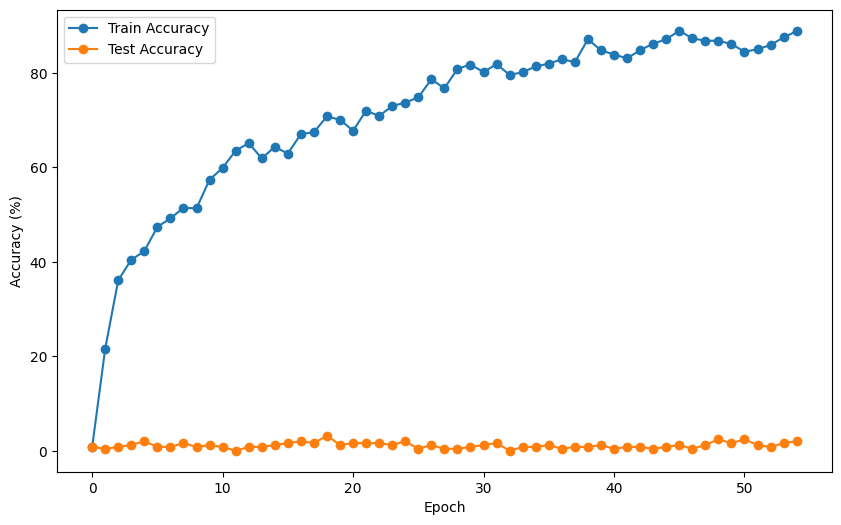

In [80]:
plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Train Accuracy', marker='o')
plt.plot(test_accuracy_history, label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

In [81]:
train_loss_history = torch.stack(train_loss_history).cpu().detach().numpy()
#train_loss_history

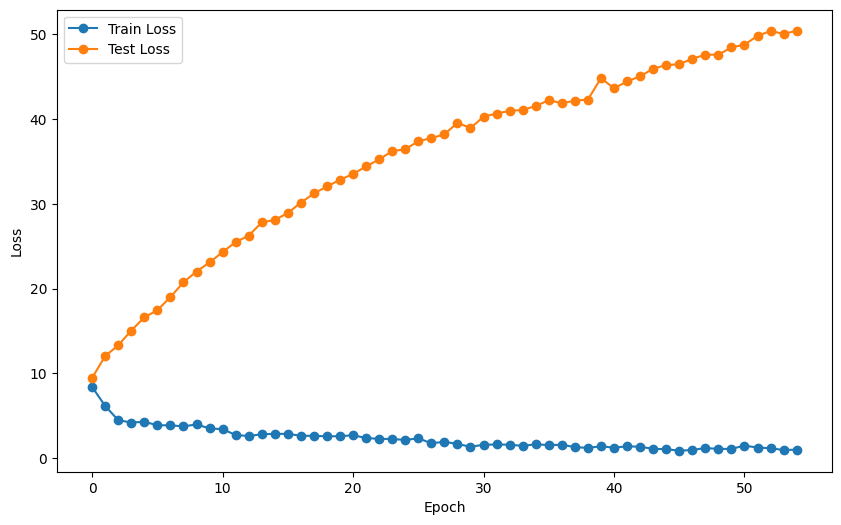

In [82]:
plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(test_loss_history, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

.. może dojść do takiej sytuacji, gdy model zaczyna zapamiętywać dane treningowe zbyt dobrze, co prowadzi do sytuacji, w której jest w stanie poprawnie przewidzieć następne słowo w danym kontekście tylko wtedy, gdy dane te pojawiają się w zbiorze treningowym. W przypadku zbioru testowego, który zawiera dane, których model nie widział wcześniej, może mieć trudności z poprawnym przewidywaniem następnego słowa.


Możliwe jest również, że model jest zbyt skomplikowany w stosunku do danych treningowych. W takim przypadku może dojść do sytuacji, w której model zaczyna dopasowywać się do szumu w danych, co prowadzi do pogorszenia jego ogólnej wydajności.


Aby rozwiązać ten problem, można spróbować:


- zmniejszyć rozmiar zbioru danych treningowych.

- dodać do zbioru danych treningowych dane losowe.

- użyć regularyzacji, która pomoże zapobiec zapamiętywaniu danych treningowych
  przez model.

- użyć mniejszego modelu.

                                          **CASE 2:**

Spróbujmy rozpatrzyć prostsze rozwiązanie:

In [83]:
X[:10]

tensor([[121, 122, 123,  50, 124],
        [122, 123,  50, 124,   9],
        [123,  50, 124,   9, 125],
        [ 50, 124,   9, 125, 126],
        [124,   9, 125, 126,  51],
        [  9, 125, 126,  51, 127],
        [125, 126,  51, 127, 128],
        [126,  51, 127, 128, 129],
        [ 51, 127, 128, 129,  18],
        [127, 128, 129,  18,   4]])

In [84]:
y[:10]

tensor([  9, 125, 126,  51, 127, 128, 129,  18,   4, 130])

In [64]:
X = torch.tensor(X)
y = torch.tensor(y)

In [65]:
batch_size = 32

dataset2 = TensorDataset(X, y)

train_loader1 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [66]:
hidden_dim1 = 60

model1 = NextWordPredictionLSTM(vocab_size, embedding_dim, hidden_dim1)
model1

NextWordPredictionLSTM(
  (embedding): Embedding(825, 128)
  (lstm): LSTM(128, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=825, bias=True)
)

In [67]:
# Definicja funkcji straty:

criterion = nn.CrossEntropyLoss()

# Definicja optymalizatora:

learning_rate1 = 0.01  # Ustalamy 'prędkość' uczenia się (learning rate)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate1)
optimizer1

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [68]:

epochs = 5  # liczba epok, czyli ile razy zbiór treningowy zostanie użyty do aktualizacji wag modelu

num_epochs = []

all_accuracies = []

all_losses = []


# Pętla wykonująca kolejne epoki treningowe:

for epoch in range(epochs):


    # ustawienie modelu w tryb trenowania:

    model1.train()


    # zmienna służąca do śledzenia bieżącej wartości funkcji straty podcza treningu:

    running_loss = 0.0


    # liczba poprawnych predykcji ( 0 jako wartość początkowa):

    correct_predictions = 0


    # całkowita liczba predykcji (0 jako wartość początkowa):

    total_predictions = 0



    # Iteracja przez dane treningowe ('train_loader'), pobieranie tzw. wsadu danych ('batch_X')
    # i odpowiadających im etykiet ('batch_y') w każdej iteracji:

    for batch_X, batch_y in train_loader1:

        # zerowanie gradientów z poprzedniej iteracji (PyTorch automatycznie akumuluje gradienty podczas propagacji wstecznej):

        optimizer1.zero_grad()


        # przekazanie wsadu danych ('batch_X') przez model, uzyskanie predykcji ('outputs'):

        outputs = model1(batch_X)


        # obliczenie straty między predykcjami ('outputs') a rzeczywistymi etykietami ('batch_y') za pomocą funkcji straty:

        loss = criterion(outputs, batch_y)


        # wsteczna propagacja, obliczanie gradientów dla wszystkich wag w modelu na pdstawie funkcji straty:

        loss.backward()


        # aktualizacja wagi modelu, zgodnie z obliczonymi gradientami podczas propagacji wstecznej:

        optimizer1.step()


        # Obliczanie dokładności:

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_y).sum().item()
        total_predictions += batch_y.size(0)


        # Sumowanie straty:
        # 'running_loss' - śledzi łączną sumę strat w danym przebiegu (batchu) podczas treningu
        # 'loss.item()' - zwraca wartość straty w postaci wykłej liczby Python'a

        running_loss += loss.item()



    # Podsumowując: każda iteracja przez wsady danych treningowych oblicza stratę, wykonuje propagację wsteczną
    #               i aktualizuje wagi modelu. Cały proces ma na celu minimalizację funkcji straty,tak aby model
    #               lepiej dopasował się do danych treningowych.



    # Wyświetlanie dokładności i średniej straty dla każdej epoki:


    accuracy = correct_predictions / total_predictions

    epoch_loss = running_loss / len(train_loader1)

    print(f'Epoch [{epoch+1}/{epochs}],    Loss: {epoch_loss},    Accuracy: {accuracy}')

    all_accuracies.append(accuracy)

    all_losses.append(loss.item())



Epoch [1/5],    Loss: 6.7386070764981785,    Accuracy: 0.014504431909750202
Epoch [2/5],    Loss: 5.406297793755164,    Accuracy: 0.16760676873489122
Epoch [3/5],    Loss: 3.5285048484802246,    Accuracy: 0.37469782433521354
Epoch [4/5],    Loss: 1.7260683133051946,    Accuracy: 0.750201450443191
Epoch [5/5],    Loss: 0.6465893257886935,    Accuracy: 0.9331184528605962


W porównaniu z pierwszym modelem (Case 1) zmniejszyliśmy liczbę neuronów w LSTM (z 200 do 60) i liczbę epok (z 55 do 5). 'Accuracy' na poziomie 90 - 92% to bardzo dobry wynik. Dalszy trening mógłby spowodować wystąpienie tzw. 'overfittingu'. 'Pozwólmy' więc modelowi na pewien stopień niepewności. W przypadku projektu przewidywania kolejnego słowa na wyjściu mamy Użytkownika końcowego, dla którego 100%-owa poprawność przewidywań może nie mieć aż tak wielkiego znaczenia, a czasem - swego rodaju niedoskonałość naszego modelu - być nową, ciekawą inspiracją..

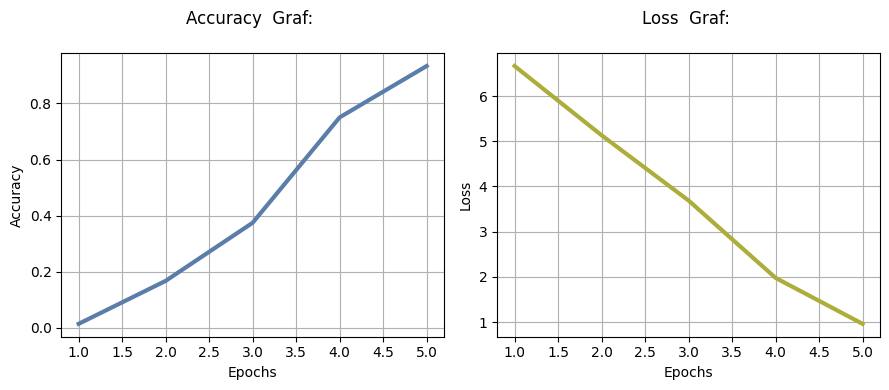

In [69]:
num_epochs1 = epochs

epoch_list = [i for i in range(1, num_epochs1 + 1, 1)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy  Graf: \n')
axes[0].grid(True)

axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss  Graf: \n')
axes[1].grid(True)

plt.tight_layout()
plt.show()


                                                                     Predykcja:

In [70]:

seq_size = 4

def create_sekwencje_testowe(tokens):
    seq_test_list = []
    for i in range(seq_size, len(tokens) + 1):
        seq = tokens[i - seq_size:i]
        seq_test_list.append(seq)
    return seq_test_list


In [71]:

sekwencje_testowe = create_sekwencje_testowe(corpus_tokens)
sekwencje_testowe[:5]


[['litwo', 'ojczyzno', 'moja', 'ty'],
 ['ojczyzno', 'moja', 'ty', 'jesteś'],
 ['moja', 'ty', 'jesteś', 'jak'],
 ['ty', 'jesteś', 'jak', 'zdrowie'],
 ['jesteś', 'jak', 'zdrowie', 'ile']]

In [72]:

# Funkcja losowego wybierania sekwencji wejściowych (testowych):

def sekwencje_wejściowe_rand(seq_list):
    idx = random.randint(0, len(seq_list))
    return seq_list[idx]


In [85]:

num_trials = 10


for i in range( 1, num_trials + 1):


  # Przykładowa sekwencja wejściowa:

  input_sequence = sekwencje_wejściowe_rand(sekwencje_testowe)


  # Konwersja słów na indeksy zgodnie ze słownikiem:

  indexed_sequence = [word_to_index[word] for word in input_sequence]


  # Konwersja na tensor PyTorch i dodanie wymiaru batcha (batch_size=1):

  input_tensor = torch.tensor([indexed_sequence], dtype=torch.int64)


  # input_tensor = input_tensor.to(device)  # Jeśli używamy GPU, dobrą praktyką jest przeniesienie tensora na GPU


# Ustawienie modelu w tryb ewaluacji:

  model1.eval()


# Przewidywanie kolejnego słowa:

  with torch.no_grad():
         outputs = model1(input_tensor)
         _, predicted_index = torch.max(outputs, 1)


  # Konwersja indeksu przewidzianego słowa na rzeczywiste słowo za pomocą słownika 'index_to_word':

         predicted_word = index_to_word[predicted_index.item()]

         print(f'Sekwencja wejściowa: {input_sequence} \n')

         print(f'Kolejne słowo: {predicted_word} \n')



Sekwencja wejściowa: ['tylko', 'co', 'wyszła', 'jeszcze'] 

Kolejne słowo: kołyszą 

Sekwencja wejściowa: ['strzelbami', 'a', 'starzy', 'i'] 

Kolejne słowo: kobiety 

Sekwencja wejściowa: ['z', 'którymi', 'się', 'zabawiać'] 

Kolejne słowo: lubił 

Sekwencja wejściowa: ['same', 'obicia', 'z', 'którymi'] 

Kolejne słowo: się 

Sekwencja wejściowa: ['westchnień', 'i', 'nowych', 'powitań'] 

Kolejne słowo: gdy 

Sekwencja wejściowa: ['stary', 'stojący', 'zegar', 'kurantowy'] 

Kolejne słowo: w 

Sekwencja wejściowa: ['na', 'świętych', 'obrazku', 'twarzy'] 

Kolejne słowo: nie 

Sekwencja wejściowa: ['której', 'lat', 'kilku', 'dzieje'] 

Kolejne słowo: chciano 

Sekwencja wejściowa: ['aż', 'do', 'piersi', 'kryje'] 

Kolejne słowo: odsłaniając 

Sekwencja wejściowa: ['poręczu', 'rozpięta', 'a', 'na'] 

Kolejne słowo: oknach 



In [74]:
# Zapis modelu:

from pathlib import Path


# Katalog modelu:

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


# Ścieżka zapisu:

MODEL_NAME = "model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# Zapis słownika:

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(), # zapis słownika implikuje zapis parametrów
           f=MODEL_SAVE_PATH)

Saving model to: models/model.pth


In [86]:
# Ładowanie modelu:


# Nowa instancja modelu (z losowymi wagami):

loaded_model = NextWordPredictionLSTM(vocab_size, embedding_dim, hidden_dim1)


# Załadowanie słownika (aktualizacja nowej instancji modelu za pomocą wyszkolonych wag):

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

                                                  Optymalizacja Hiperparametrów:


- to proces doboru takich parametrów modelu, które zapewniają najlepsze wyniki.

Wyróznia się 'parametry' i 'hiperparametry'.

'Parametry' to te parametry, które służa w naszej sieci neuronowej (i nie tylko) do obliczeń jej wyjścia. O ich wartościach decyduje algorytm.
Są to m.in.: wagi, bias.

'Hiperparametry' również wpływają na wyniki, jednak, w odróżnieniu od parametrów, można je 'recznie dostrajać'. Są to m.in.: współczynnik uczenia (learning_rate), liczba warstw ukrytych, liczba neuronów w warstwie, liczba epok treningowych, optymalizator czy funkcja straty.

Istnieją dwa wiodące podejścia doboru hiperparametrów:

1. GridSearch - wybieramy ręcznie wartości parametrów + trening modelu dla każdej możliwej kombinacji.

2. Random Search - wybór zestawu parametrów następuje w drodze losowania.

Biblioteka Scikit-Learn udostępnia dla tych operacji odpowiednie klasy (obiekty) - GridSearchCV i RandomizedSearchCV.
